# NeqSim in jupyter

NeqSim can be run from jupyter by using the py4j python package

##Example 1 Setting up a thermodynamic calculation using NeqSim

In [1]:
from py4j.java_gateway import *
neqsim =  JavaGateway().jvm.neqsim

thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,10.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("water", 4.0)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()

#thermoSystem.display()

gasEnthalpy = thermoSystem.getPhase(0).getEnthalpy()

thermoSystem.initPhysicalProperties("Viscosity")
gasViscosity = thermoSystem.getPhase(0).getViscosity("kg/msec")

print("Gas enthalpy ", gasEnthalpy)
print("Gas viscosity ", gasViscosity)

Gas enthalpy  1079.483954492986
Gas viscosity  1.0507234883676986e-05


##Example 2 Calculation of a phase envelope using NeqSim

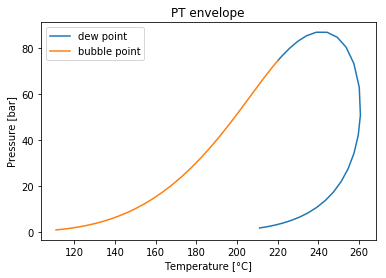

In [2]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,10.0)
thermoSystem.addComponent("nitrogen", 1.0)
thermoSystem.addComponent("methane", 70.0)
thermoSystem.addComponent("ethane", 4.0)
thermoSystem.addComponent("propane", 2.0)
thermoSystem.addComponent("i-butane", 1.0)
thermoSystem.addComponent("n-butane", 1.0)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.calcPTphaseEnvelope()

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(thermoOps.getOperation().get("dewT")),list(thermoOps.getOperation().get("dewP")), label="dew point")
plt.plot(list(thermoOps.getOperation().get("bubT")),list(thermoOps.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [\u00B0C]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

##Example 3 Calculation of hydrate equilibrium temperature using NeqSim

In [3]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,60.0)
thermoSystem.addComponent("methane", 90.0)
thermoSystem.addComponent("ethane", 10.0)
thermoSystem.addComponent("propane", 1.0)
thermoSystem.addComponent("water", 4.0)
thermoSystem.setHydrateCheck(True);
thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.hydrateFormationTemperature()

print("Hydrate equilibrium temperature ", thermoSystem.getTemperature()-273.15, " C")

Hydrate equilibrium temperature  15.407359934325314  C
